In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import pdb
from tqdm import tqdm

import scipy.stats as stats
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from joblib import Parallel, delayed

from gimmemotifs.motif import Motif, read_motifs

np.random.seed(97)

/global/scratch/users/aniketh/mamba_envs/gimme/lib/python3.10/site-packages/tqdm/autonotebook.py:19: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  warn(WARN_NOIPYW, TqdmWarning, stacklevel=2)


In [2]:
def create_fasta(seqs, file_path):
    with open(file_path, "w+") as f:
        for i, seq in enumerate(seqs):
            f.write(f">{i}\n")
            f.write(f"{seq}\n")

In [3]:
def get_all_motifs_from_meme_file(meme_file):
    meme_file = open(meme_file, "r").readlines()
    all_motifs = []

    for i, line in enumerate(meme_file):
        if line.startswith("MOTIF "):
            j = i
            motif_name = meme_file[j].split(" ")[1]
            while(not meme_file[j].startswith("letter-probability matrix")):
                j += 1
            length = int(meme_file[j].split(" ")[5])
            j += 1

            pwm = []
            while(j < len(meme_file) and (not meme_file[j].startswith("MOTIF")) and len(meme_file[j].strip()) > 0):
                pos_prob = [float(i.strip()) for i in meme_file[j].strip().split()]
                pwm.append(pos_prob)
                assert len(pos_prob) == 4
                j += 1
            pwm = np.array(pwm)
            assert pwm.shape[0] == length
            assert pwm.shape[1] == 4

            m = Motif(pwm)
            m.id = motif_name

            all_motifs.append(m)

    return all_motifs

def create_pfm_from_meme(meme_file, pfm_file_path):
    all_motifs = get_all_motifs_from_meme_file(meme_file)
    print(f"Got all {len(all_motifs)} from MEME file at {meme_file}")
    
    pfm_file = open(pfm_file_path, "w+")
    for motif in all_motifs:
        for line in motif.to_pfm():
            pfm_file.write(line)
        pfm_file.write("\n")
    pfm_file.close()

In [4]:
final_design_seqs_dir = "/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/"

denovo_motif_analysis_results_dir = "/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/denovo_motif_analysis"
known_motif_analysis_results_dir = "/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/known_motif_analysis"

os.makedirs(denovo_motif_analysis_results_dir, exist_ok=True)
os.makedirs(known_motif_analysis_results_dir, exist_ok=True)

bashrc_path = "/global/home/users/aniketh/.bashrc"
conda_env_path = "/global/scratch/users/aniketh/mamba_envs/gimme"
scripts_dir = "/global/home/users/aniketh/promoter/promoter"

meme_file = "/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/consensus_pwms.meme"
pfm_file_path = "/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/consensus_pwms.pfm"

In [5]:
create_pfm_from_meme(meme_file, pfm_file_path)

Got all 693 from MEME file at /global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/consensus_pwms.meme


In [6]:
len(read_motifs(pfm_file_path))

693

In [7]:
methods = ["coms", "dens"]
num_seqs = [None, None]
all_seqs = []
all_sources = []
for i, method in enumerate(methods):
    print(method, num_seqs[i])
    seqs = pickle.load(open(os.path.join(final_design_seqs_dir, f"{method}_final_design.pkl"), "rb"))
    for cell in ["jurkat", "k562", "thp1"]:
        seqs[cell].pop("kmer_features")
        df = pd.DataFrame(seqs[cell])
        df["designed_for"] = cell
        
        if num_seqs[i] is not None:
            df = df.tail(num_seqs[i])
        
        fasta_file_path = os.path.join(denovo_motif_analysis_results_dir, f"{method}_{cell}.fa")
        denovo_analysis_outdir_dir = os.path.join(denovo_motif_analysis_results_dir, f"{method}_{cell}.gimme")
        known_analysis_output_path = os.path.join(known_motif_analysis_results_dir, f"{method}_{cell}.gtf")
        
        create_fasta(df["sequences"], fasta_file_path)
        
        cmd = f"sbatch --requeue --export=bashrc_path={bashrc_path},conda_env_path={conda_env_path},scripts_dir={scripts_dir},fasta_path={fasta_file_path},denovo_output_dir={denovo_analysis_outdir_dir},known_analysis_output_path={known_analysis_output_path},pfm_file_path={pfm_file_path} QC4_motif_analysis.sh"
        print(cmd)
        
        for export in cmd.split(" ")[2][len("--export="):].split(","):
            export = export.split("=")
            print(f"export {export[0]}={export[1]}")
        print()
        
        if i == 0 and cell == "jurkat":
            continue
        os.system(cmd)
        print("Submitted!")

coms None
sbatch --requeue --export=bashrc_path=/global/home/users/aniketh/.bashrc,conda_env_path=/global/scratch/users/aniketh/mamba_envs/gimme,scripts_dir=/global/home/users/aniketh/promoter/promoter,fasta_path=/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/denovo_motif_analysis/coms_jurkat.fa,denovo_output_dir=/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/denovo_motif_analysis/coms_jurkat.gimme,known_analysis_output_path=/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/known_motif_analysis/coms_jurkat.gtf,pfm_file_path=/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/consensus_pwms.pfm QC4_motif_analysis.sh
export bashrc_path=/global/home/users/aniketh/.bashrc
export conda_env_path=/global/scratch/users/aniketh/mamba_envs/gimme
export scripts_dir=/global/home/users/aniketh/promoter/promoter
export fasta_path=/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/denovo_motif_

coms
jurkat
k562
thp1


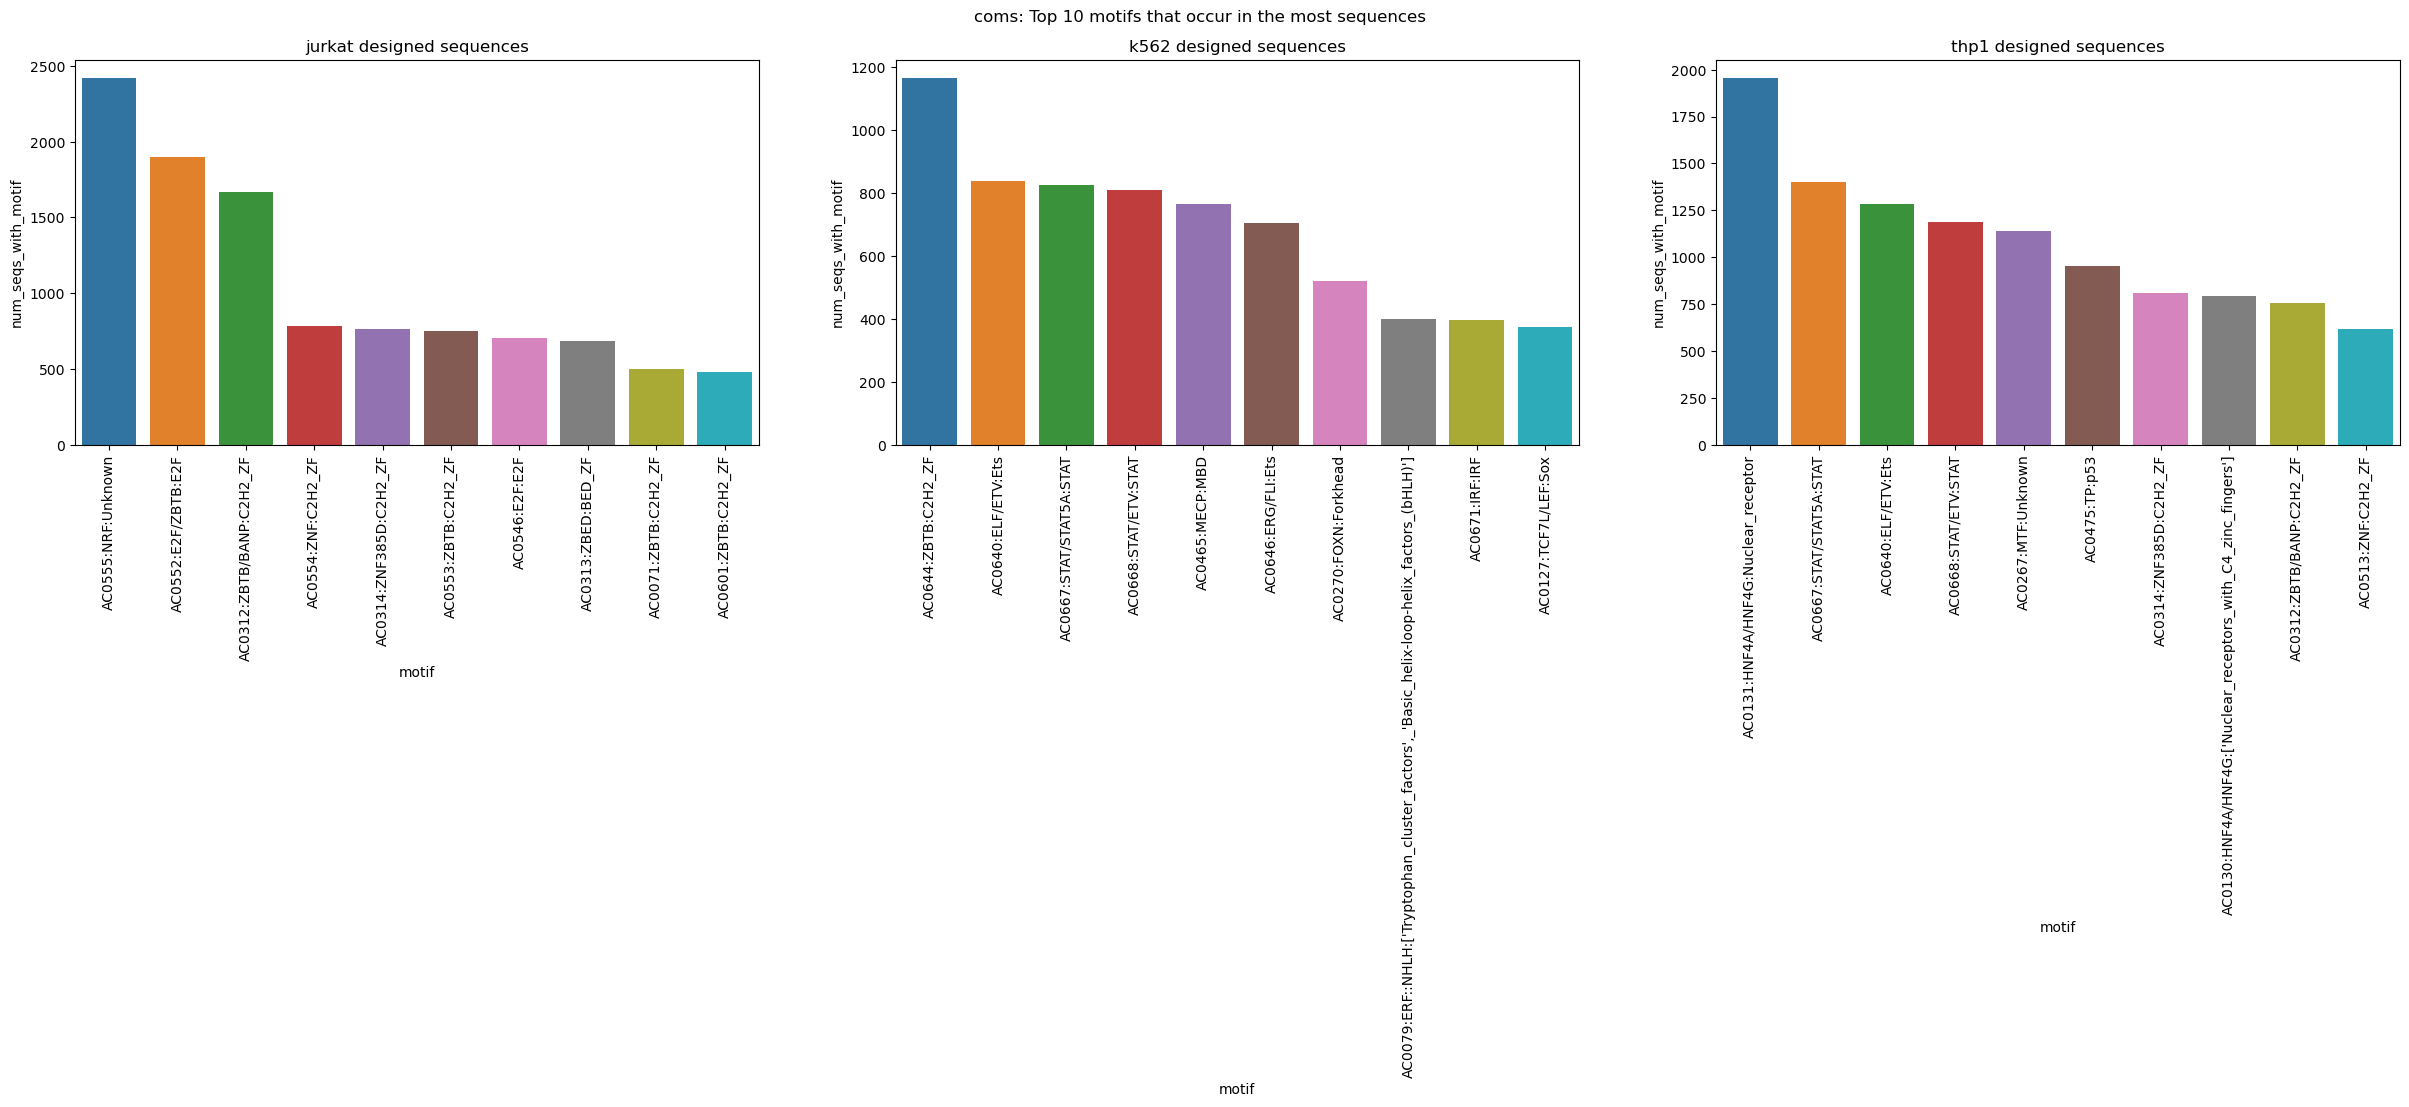

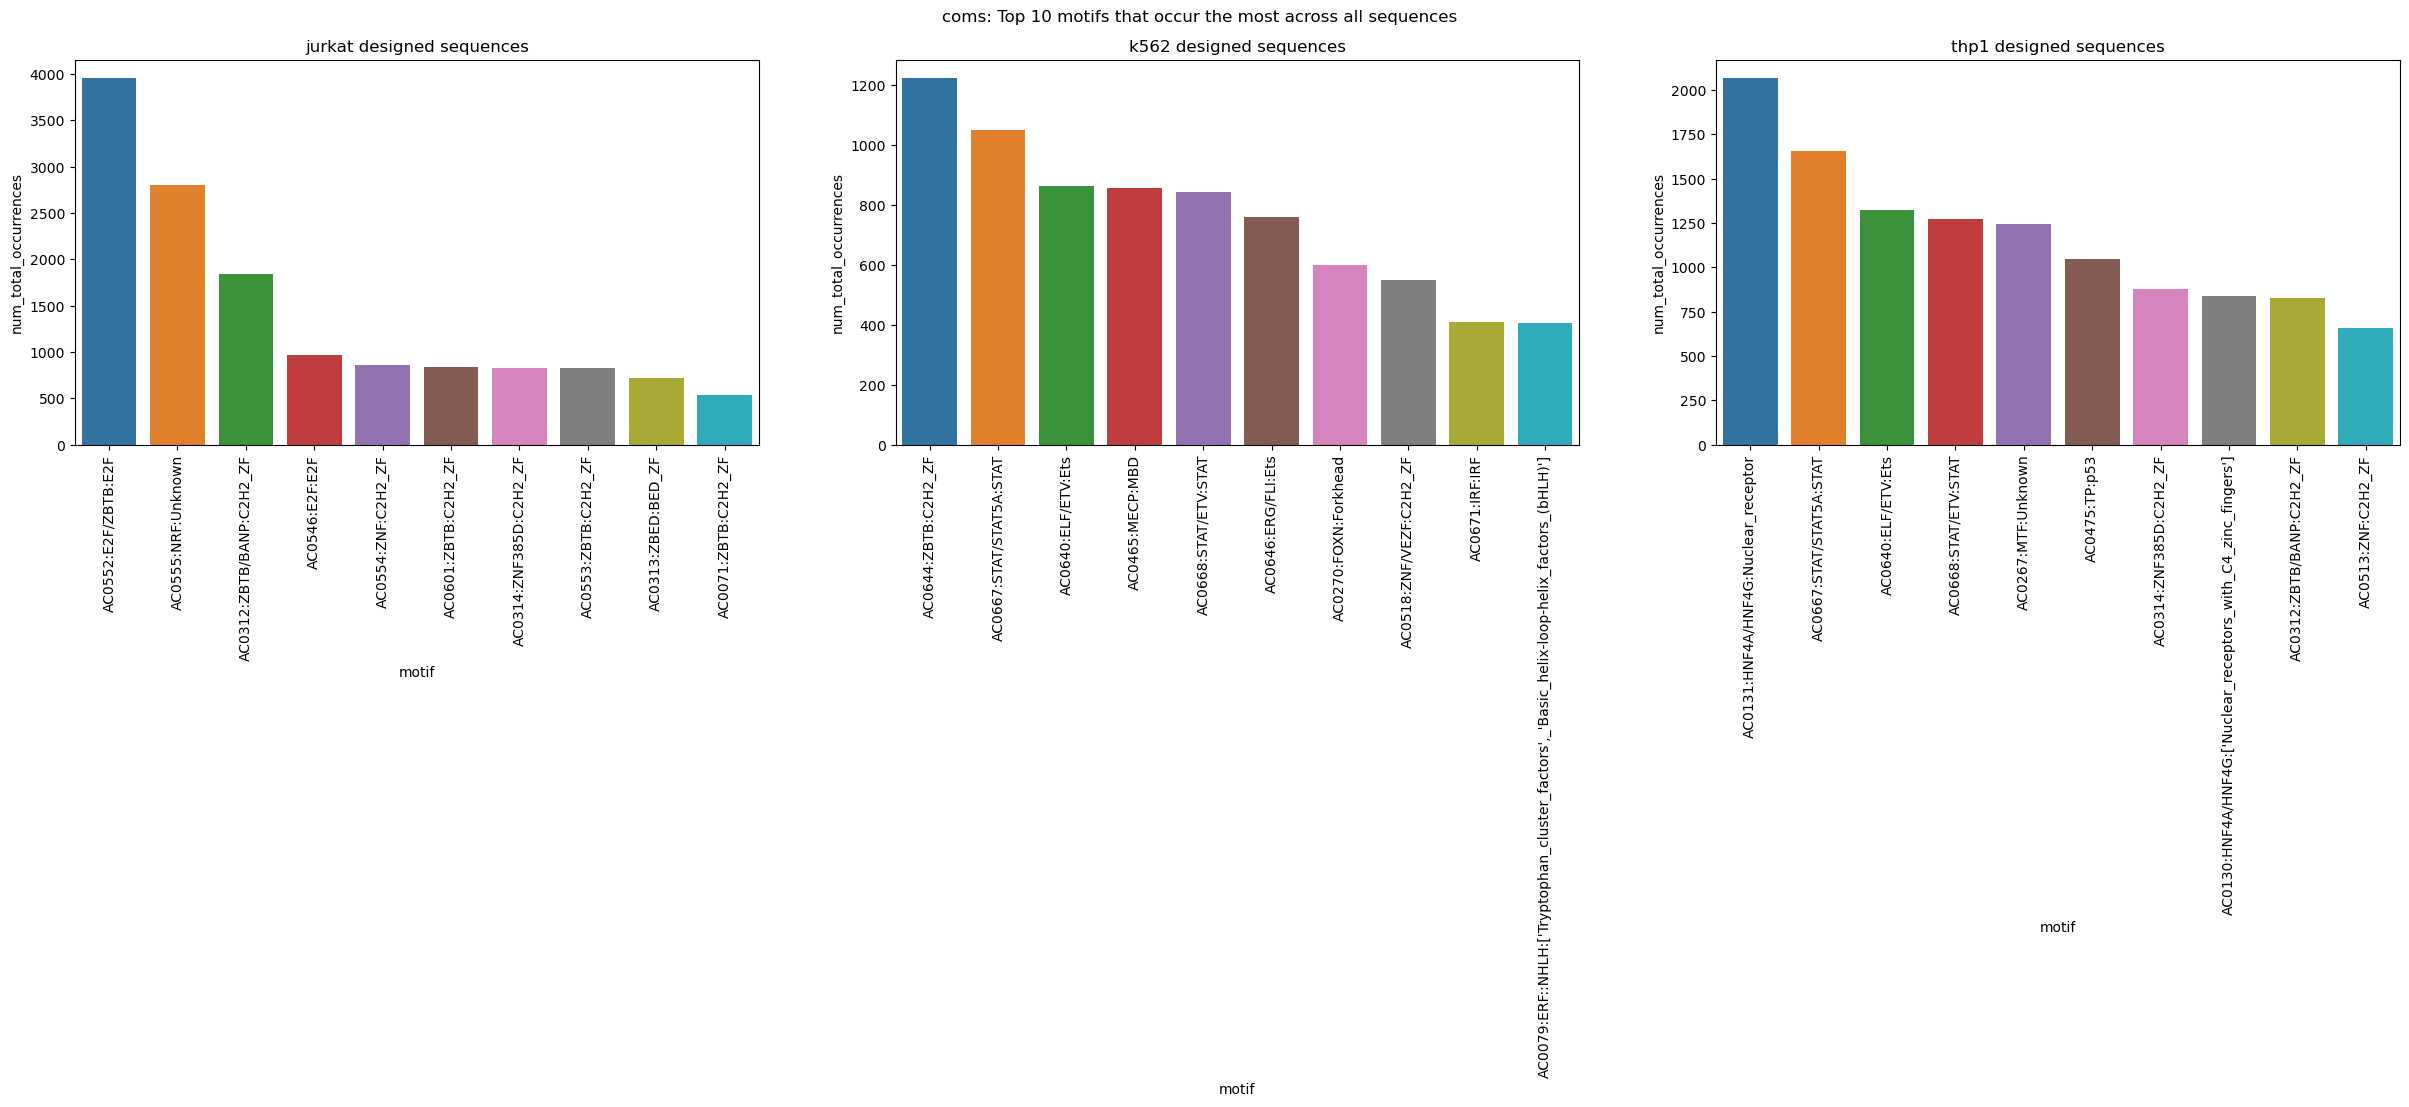

dens
jurkat
k562
thp1


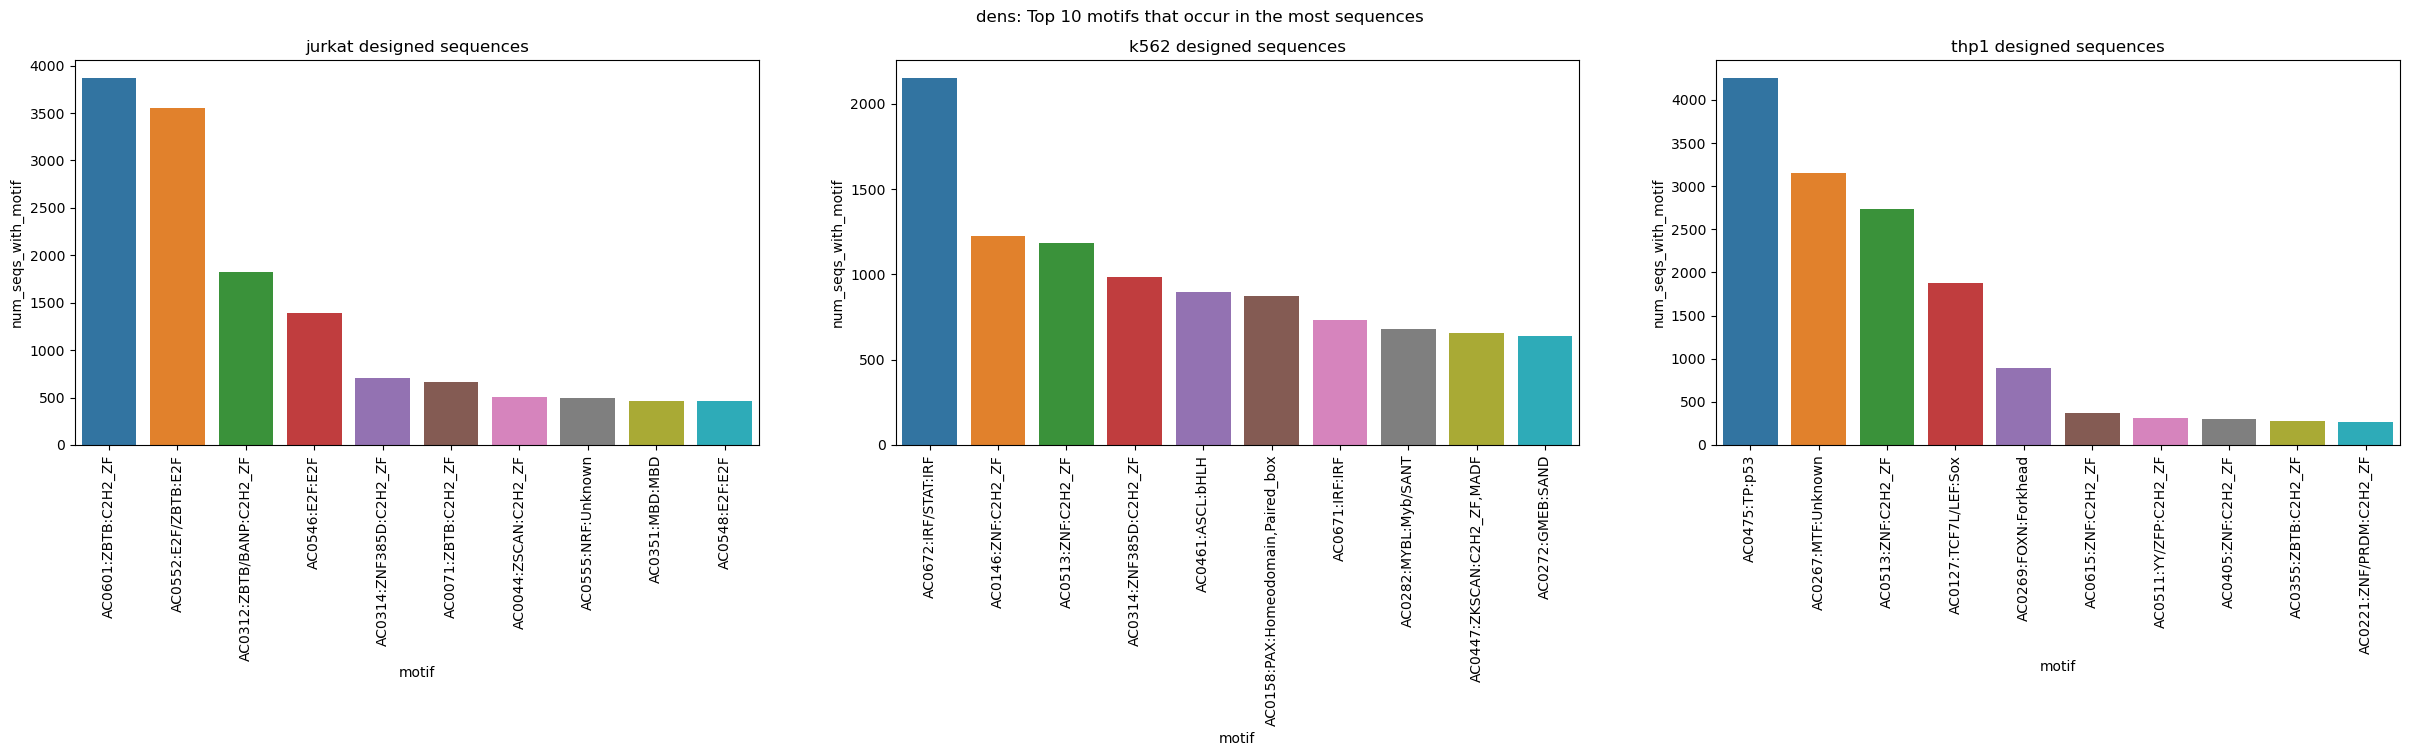

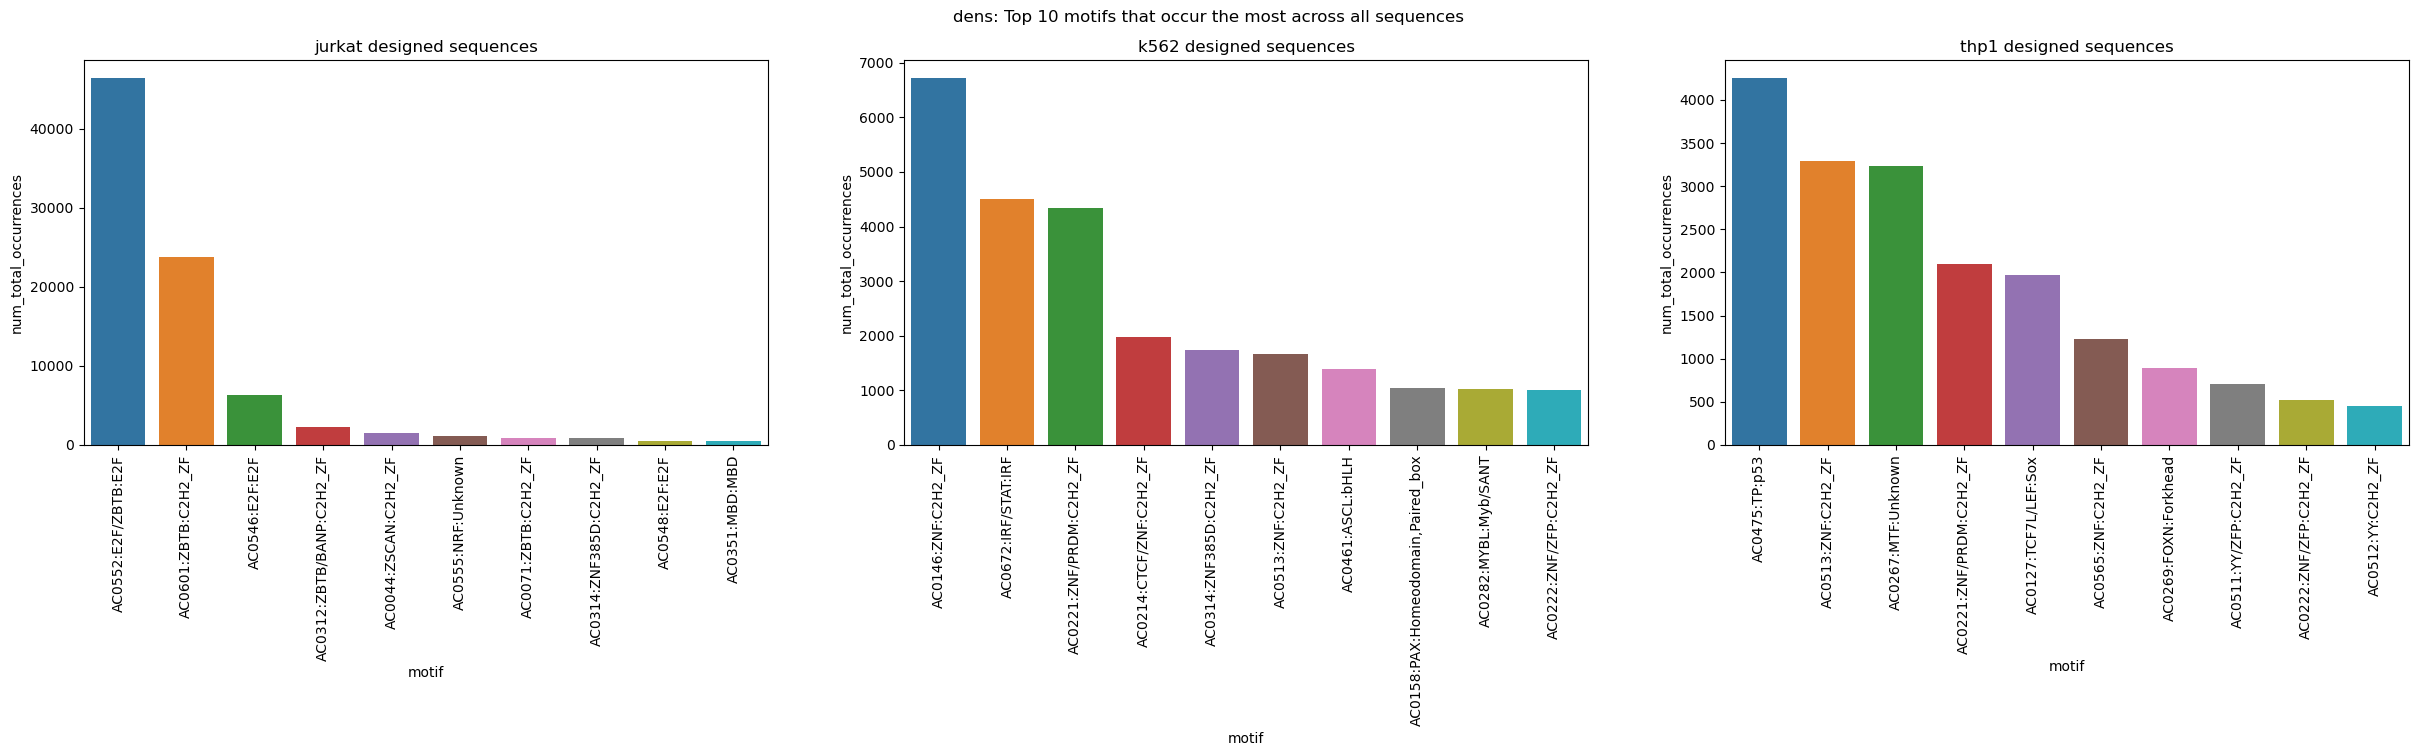

In [20]:
methods = ["coms", "dens"]
for i, method in enumerate(methods):
    print(method)
    
    fig, ax = plt.subplots(1, 3, figsize=(30, 5))
    fig2, ax2 = plt.subplots(1, 3, figsize=(30, 5))
    
    for p, cell in enumerate(["jurkat", "k562", "thp1"]):
        print(cell)
        
        try:
            df = pd.read_csv(os.path.join(known_motif_analysis_results_dir, f"{method}_{cell}.gtf"), sep="\t", skiprows=5, index_col=None, header=None)
        except:
            continue
            
        motif_occurrences = {}
        
        for j in range(len(df)):
            row = df.iloc[j]
            motif_info = row[8]
            motif_name = motif_info.split()[1][1:-1]
            
            if motif_name not in motif_occurrences:
                motif_occurrences[motif_name] = []
            
            motif_occurrences[motif_name].append(row[0])
            
        motif_df = {}
        motif_df["motif"] = []
        motif_df["num_seqs_with_motif"] = []
        motif_df["num_total_occurrences"] = []
        
        for m in motif_occurrences:
            motif_df["motif"].append(m)
            motif_df["num_seqs_with_motif"].append(len(set(motif_occurrences[m])))
            motif_df["num_total_occurrences"].append(len(motif_occurrences[m]))
            
        motif_df = pd.DataFrame(motif_df)
        
        sns.barplot(data=motif_df.sort_values(by="num_seqs_with_motif", ascending=False).head(10), 
                    x="motif", y="num_seqs_with_motif", ax=ax[p])
        ax[p].set_xticklabels(motif_df.sort_values(by="num_seqs_with_motif", ascending=False).head(10)["motif"], 
                              rotation = 90)
        ax[p].set_title(f"{cell} designed sequences")
        
        sns.barplot(data=motif_df.sort_values(by="num_total_occurrences", ascending=False).head(10), 
                    x="motif", y="num_total_occurrences", ax=ax2[p])
        ax2[p].set_xticklabels(motif_df.sort_values(by="num_total_occurrences", ascending=False).head(10)["motif"], 
                               rotation = 90)
        ax2[p].set_title(f"{cell} designed sequences")

    fig.suptitle(f"{method}: Top 10 motifs that occur in the most sequences")
    fig2.suptitle(f"{method}: Top 10 motifs that occur the most across all sequences")
    plt.show()